In [ ]:
# Zainstaluj bibliotekę Gymnasium i PyTorch
!pip install "gymnasium[box2d]==0.28" torch matplotlib numpy

In [ ]:
# Zobacz jak działają środowiska na przykładzie 100 kroków
import gymnasium as gym

#env = gym.make("CartPole-v1", render_mode="human")
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()

for _ in range(100):
    # Pokaż obraz z środowiska
    env.render()

    # Wybierz losową akcję z przestrzeni akcji
    action = env.action_space.sample()

    # Wykonaj akcję i otrzymaj informację o kolejnym stanie, nagrodzie 
    # i czy środowisko zostało zakończone.
    # Zobacz https://gymnasium.farama.org/api/env/#gymnasium.Env.step 
    # by sprawdzić opis wszystkich zwracanych wartości.
    observation, reward, term, trunc, _ = env.step(action)
    done = term or trunc
    
    if done:
        observation, info = env.reset()
env.close()

In [ ]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

Przestrzeń stanów: Box([-90.        -90.         -5.         -5.         -3.1415927  -5.
  -0.         -0.       ], [90.        90.         5.         5.         3.1415927  5.
  1.         1.       ], (8,), float32)
Rozmiar wektora reprezntującego stany: (8,)
Ostatnia obserwacja: <class 'numpy.ndarray'> [ 0.07356767  1.4444239   0.43162695 -0.03933519 -0.13253745 -0.28196266
  0.          0.        ]
Przestrzeń akcji: Discrete(4)
Ilość możliwych akcji: 4


In [ ]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [ ]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    plt.plot(rewards)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
    rewards = []
    for episode in range(episodes):
        observation, _ = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards)
    return rewards    

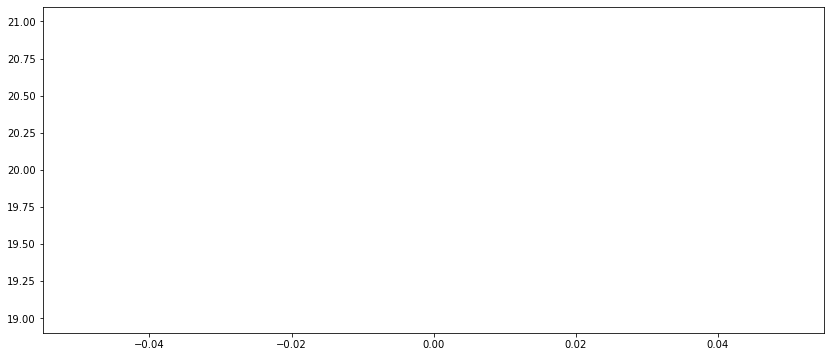

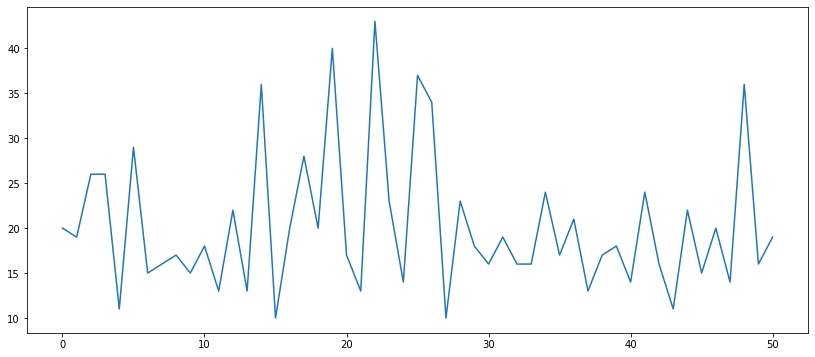

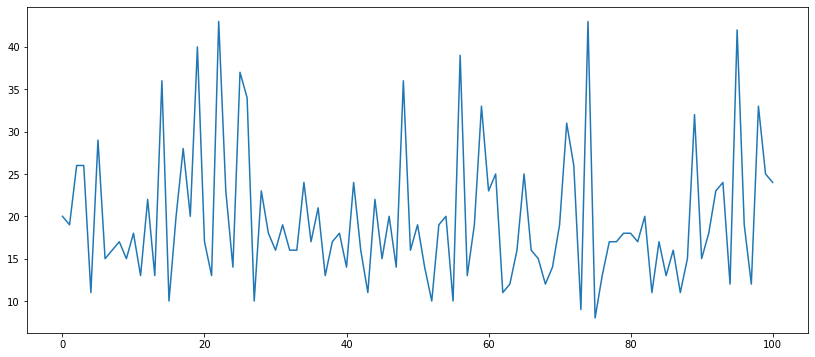

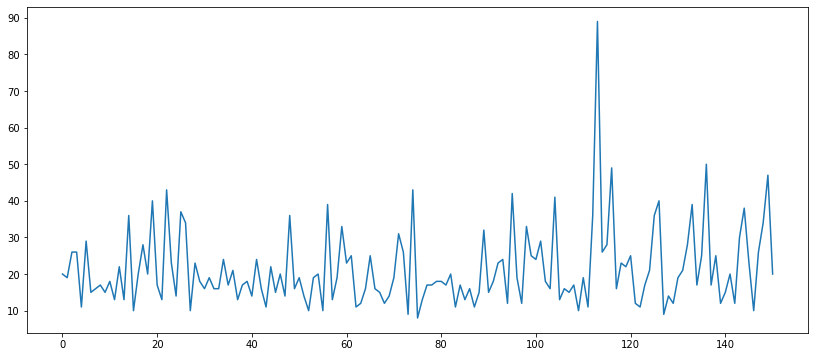

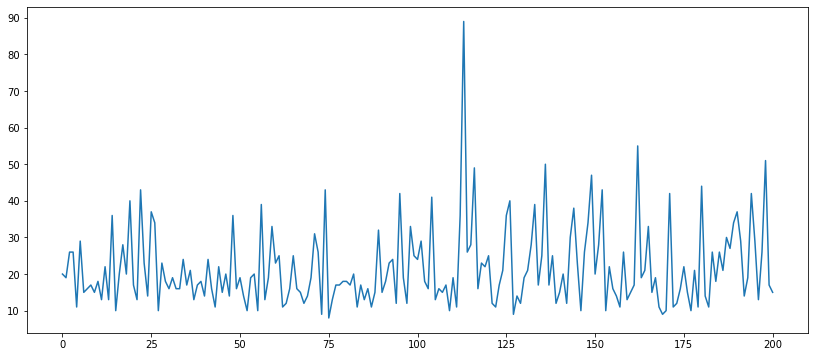

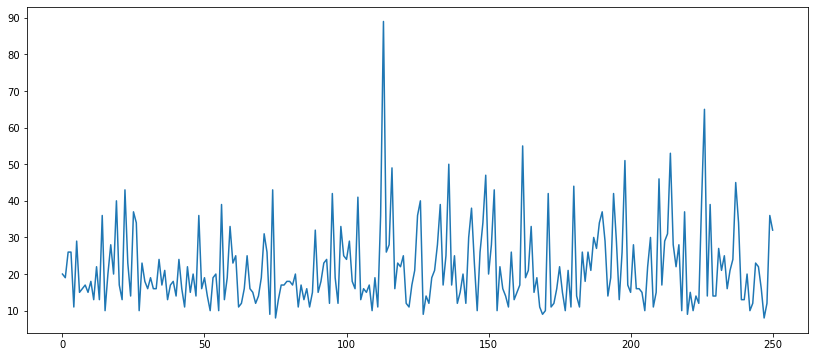

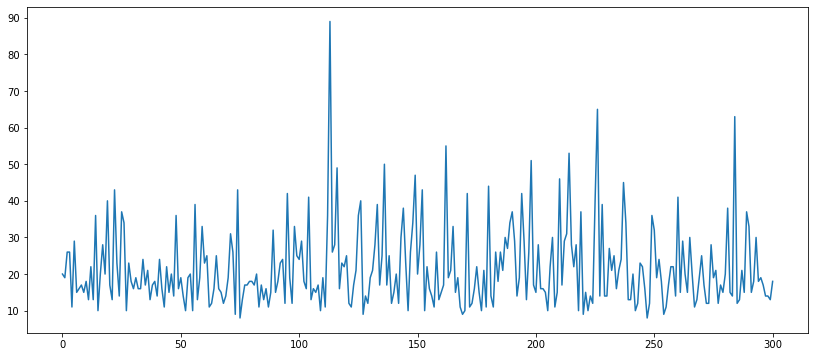

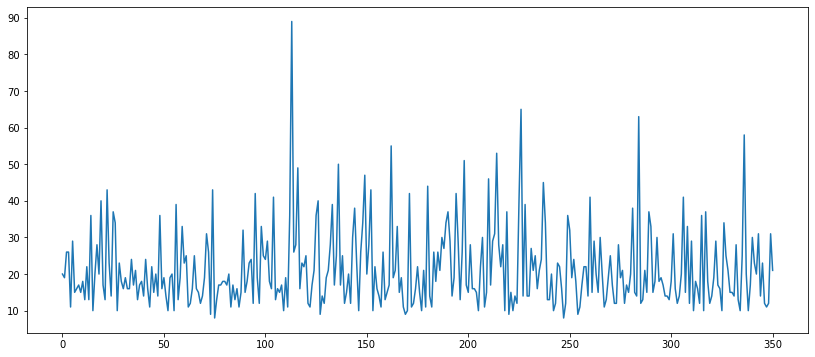

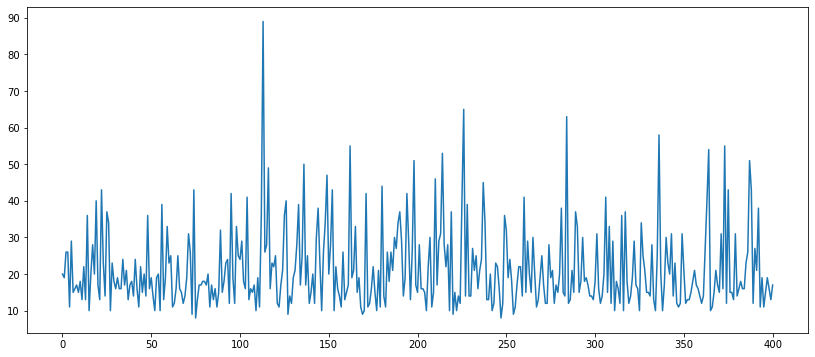

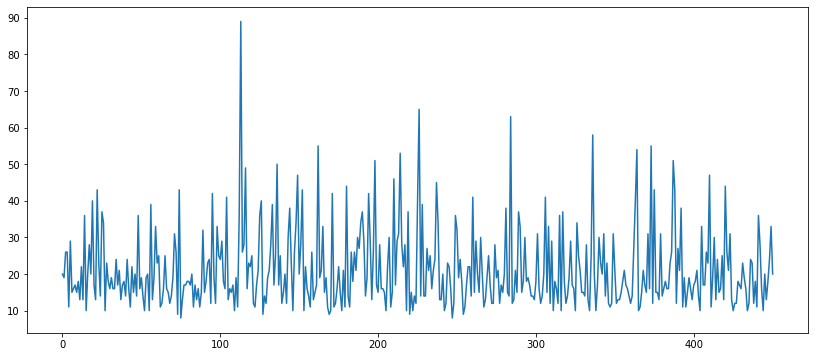

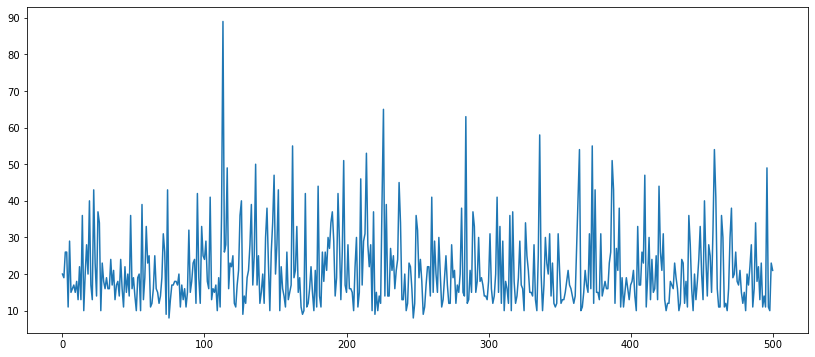

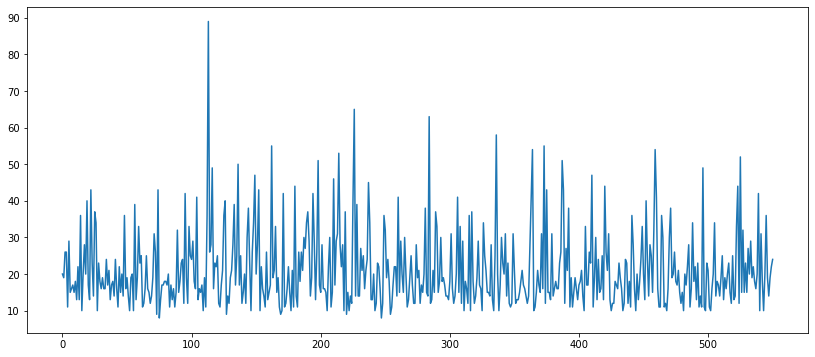

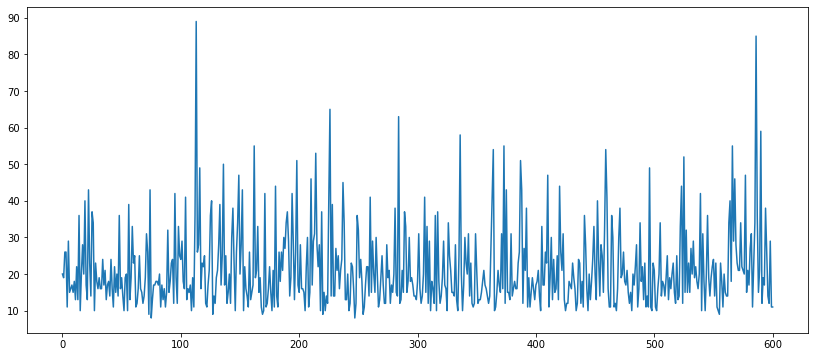

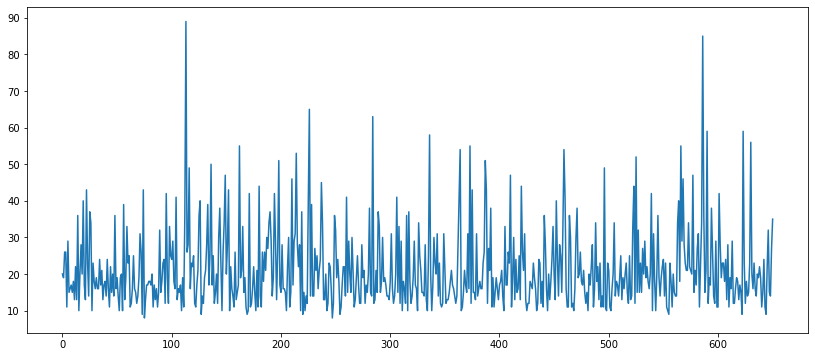

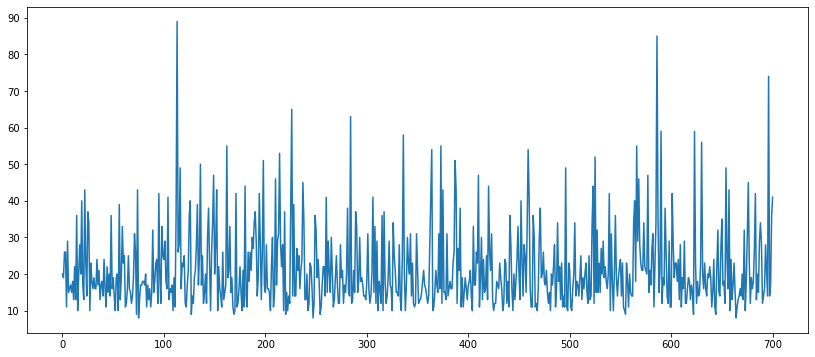

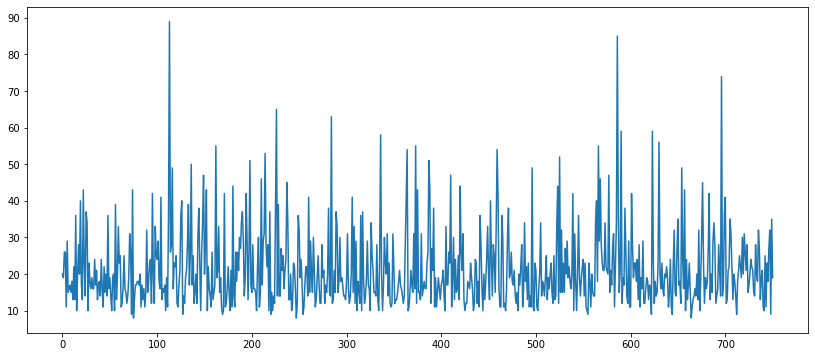

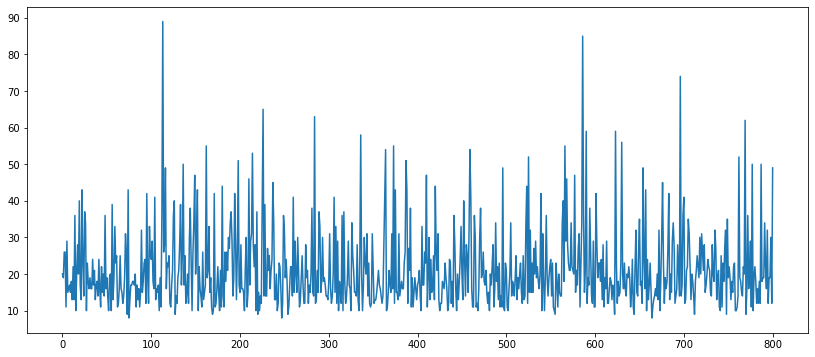

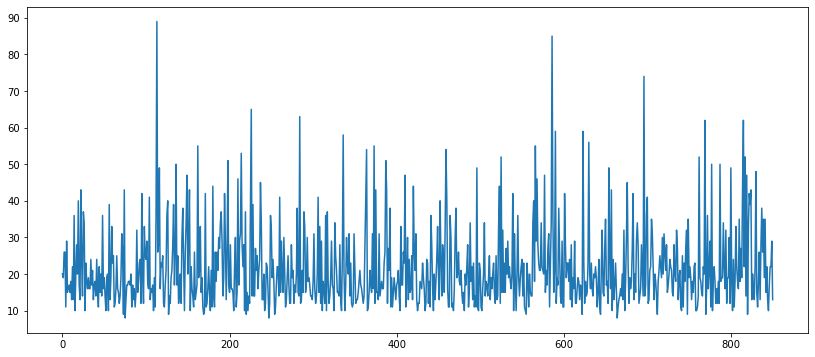

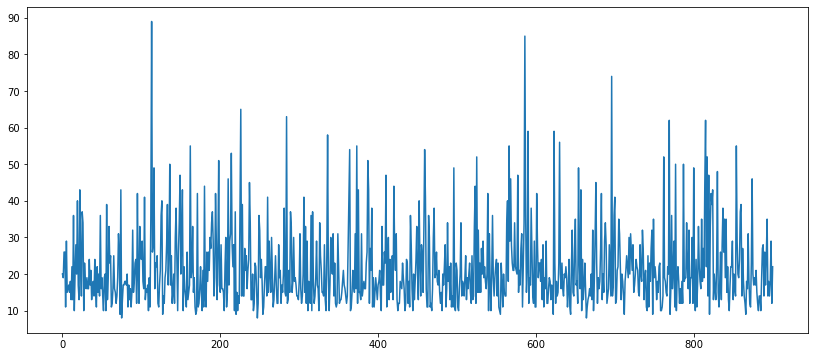

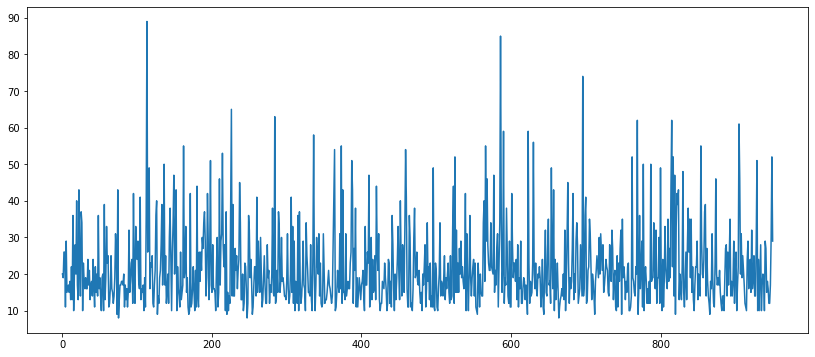

In [ ]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    
    def process_transition(self, observation, action, reward, next_observation, done):
        pass
        
    def get_action(self, observation, learning):
        return self.action_space.sample()
    
random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

## Tabularyczny Q-Learning 

In [ ]:
from numpy.lib.polynomial import polyder
import numpy as np
import operator as op
class TabularQLearningAgent(Agent):
    def __init__(self, env, eps=0.7,eps_decay=0.999, alfa=0.3, alfa_decay=0.999, gamma=0.99):
        super().__init__(env)
        # Zainicjalizuj tutaj swojego agenta
        self.num_bins = np.array([10,10,20,20])
        self.Q = np.random.random_sample(np.append(self.num_bins, env.action_space.n))
        self.eps = eps
        self.eps_decay = eps_decay
        self.alfa = alfa
        self.alfa_decay = alfa_decay
        self.gamma = gamma
        self.env = env
    
    def process_transition(self, observation, action, reward, next_observation, done):
        # Miejsce na Twoją implementację
        if done:
            self.eps = 0.01 if self.eps * self.eps_decay < 0.01 else self.eps * self.eps_decay
            self.alfa = 0.01 if self.alfa * self.alfa_decay < 0.01 else self.alfa * self.alfa_decay
            self.Q[self.quantization(next_observation)] = [0.0] * self.env.action_space.n
        tmp = self.Q[tuple((*self.quantization(observation), action))]
        self.Q[tuple((*self.quantization(observation), action))] = tmp - self.alfa * (tmp - (reward + self.gamma * np.max(self.Q[tuple((self.quantization(next_observation)))]))) 

        
    def get_action(self, observation, learning):
        if learning and op.lt(np.random.rand(), self.eps):
            return self.action_space.sample()
        return np.argmax(self.Q[tuple(self.quantization(observation))])
    
    def quantization(self, observation):
        cart_position = np.linspace(-4.8, 4.8, num=self.num_bins[0] - 1)
        cart_velocity = np.linspace(-2, 2, num=self.num_bins[1] - 1)
        pole_angel = np.linspace(-0.4, 0.4, num=self.num_bins[2] - 1)
        pole_angel_velocity = np.linspace(-2, 2, num=self.num_bins[3] - 1)
        return np.digitize(observation[0], cart_position), np.digitize(observation[1], cart_velocity), np.digitize(observation[2], pole_angel), np.digitize(observation[3], pole_angel_velocity) 

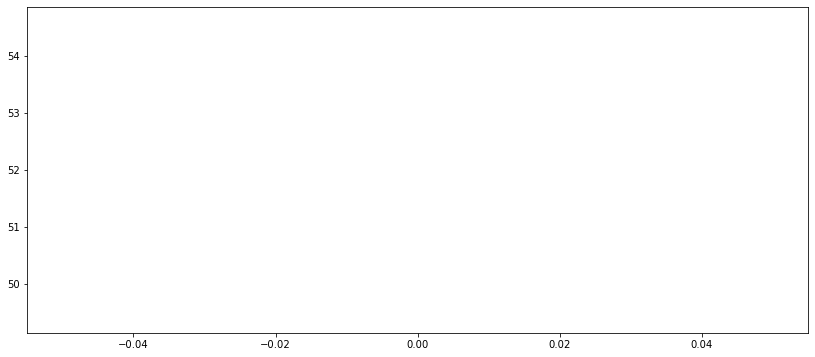

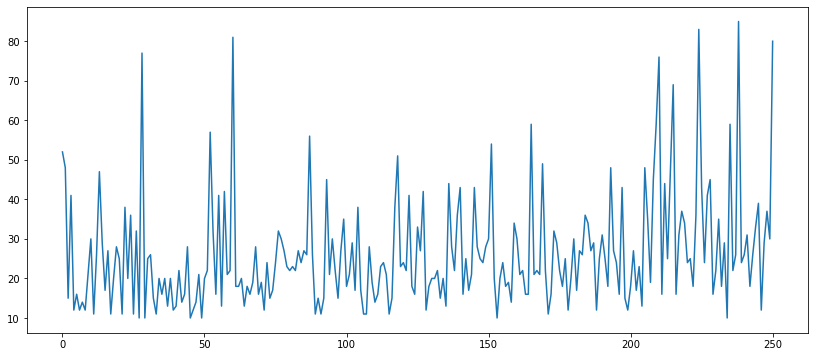

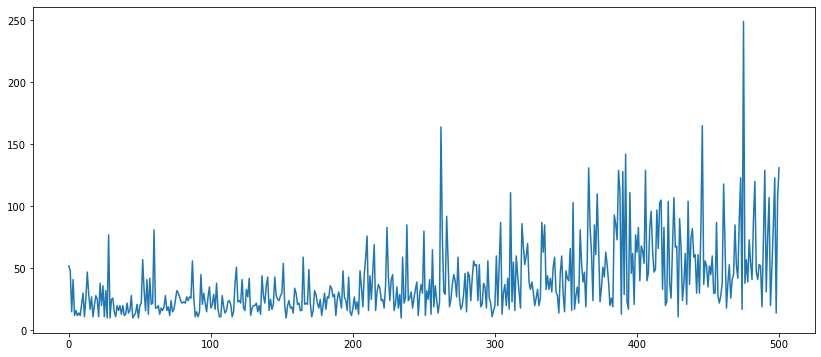

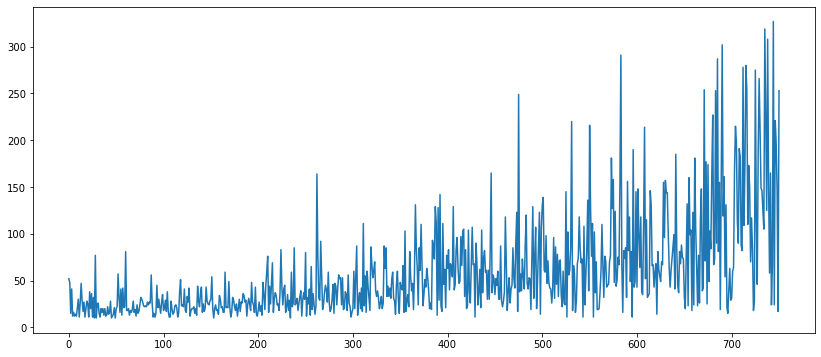

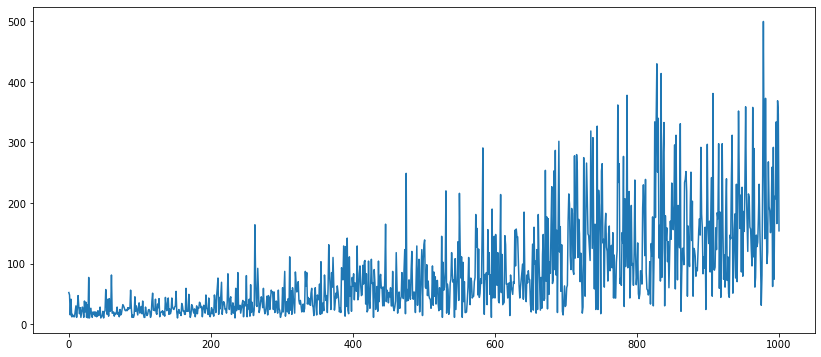

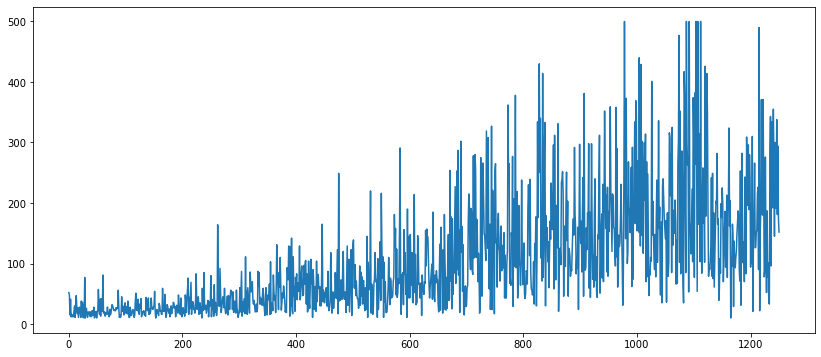

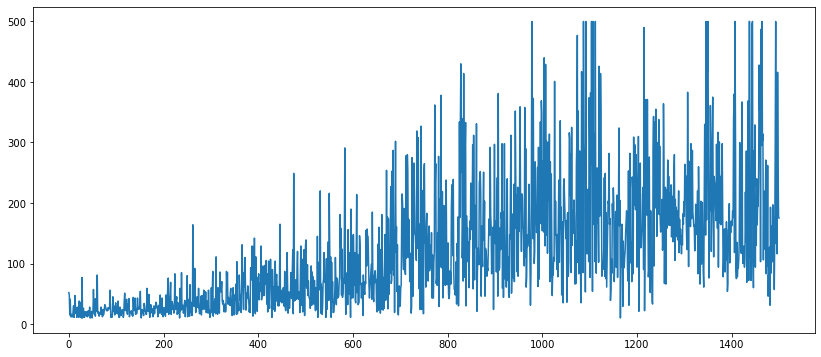

In [ ]:
# Uczenie/testowania agenta
env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 1750, learning=True, plot=True, plot_interval=250)

In [ ]:
test_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=False, plot_interval=250)
np.mean(test_rewards)

449.279

## Q-Learning z aproksymacją



In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from copy import deepcopy
import numpy as np
import operator as op
import random
from collections import deque

class MyModel(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(MyModel, self).__init__()
        self.input = torch.nn.Linear(n_feature, n_hidden)  # Warstwa wejściowa
        self.hidden = torch.nn.Linear(n_hidden, n_hidden)
        self.output = torch.nn.Linear(n_hidden, n_output)  # Warstwa wyjściowa

    # W momencie wykonania tych operacji zostanie stworzony graf obliczeniowy, który zostanie wykorzystany do propagacji wstecznej
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)  # Wejście + funkcja aktywacji
        x = self.hidden(x)
        x = F.relu(x)
        x = self.output(x)         # Liniowe wyjście
        return x
    
    def predict(self, S):
        with torch.no_grad():  # Wyłączenie liczenia gradientów dla bloku poniżej
            return self(torch.Tensor(S))
        


class NeuralQLearningAgent(Agent):
    def __init__(self, env, eps=1.0,eps_decay=0.999, alpha=0.0005, J=32, gamma=0.99, memory_capacity=1000, sync_freezing=10, use_replay_memory=False, use_freezing=False, use_double_q=False):
        super().__init__(env)
        # Zainicjalizuj tutaj swojego agenta
        self.eps = eps
        self.eps_decay = eps_decay
        self.gamma = gamma
        self.use_freezing = use_freezing
        self.sync_freezing = sync_freezing
        self.use_replay_memory = use_replay_memory
        self.use_double_q = use_double_q
        self.iter = 0
        self.J = J
        

        self.Q = MyModel(env.observation_space.shape[0], 128, env.action_space.n)
        self.Q_target = deepcopy(self.Q) if use_freezing else self.Q
        self.optim = torch.optim.Adam(self.Q.parameters(), lr=alpha)
        self.loss = torch.nn.MSELoss()

        
        self.memory = deque(maxlen=memory_capacity)

    
    

    def process_transition(self, observation, action, reward, next_observation, done):
        
        if self.use_replay_memory:
            observation_t, next_observation_t = torch.tensor(observation), torch.tensor(next_observation)
            self.memory.append((observation_t, action, reward, next_observation_t, done))
            if op.eq(op.mod(self.iter, 8), 0):
                batch = random.sample(self.memory, min(self.J, len(self.memory)))
                batch_q_values = []
                pred_actions = []
                for observation, action, reward, next_observation, done in batch:
                    if done:
                        target = reward
                    else:
                        if self.use_double_q:
                            A = torch.argmax(self.Q.predict(next_observation)).item()
                            target = op.add(reward , op.mul(self.gamma, self.Q_target.predict(next_observation)[A])) 
                        else:
                            target = op.add(reward , op.mul(self.gamma, torch.max(self.Q_target.predict(next_observation))))
                    p = self.Q(torch.Tensor(observation))
                    pred_actions.append(p[action])
                    batch_q_values.append(target)


                self.optim.zero_grad()
                loss = self.loss(torch.stack((pred_actions)), Variable(torch.Tensor(batch_q_values)))
                loss.backward()
                self.optim.step()
        
        else:
            observation_t, next_observation_t = torch.tensor(observation), torch.tensor(next_observation)
            pred = self.Q(observation_t)[action]
            
            if done:
                target = reward
            else:
                if self.use_double_q:
                    A = torch.argmax(self.Q.predict(next_observation_t)).item()
                    target = op.add(reward , op.mul(self.gamma, self.Q_target.predict(next_observation_t)[A])) 
                else:
                    target = op.add(reward , op.mul(self.gamma, torch.max(self.Q_target.predict(next_observation_t))))
            
            self.optim.zero_grad()
            loss = self.loss(pred, torch.Tensor([target]))
            loss.backward()
            self.optim.step()
    
            
        if op.and_(op.or_(self.use_freezing, self.use_double_q), op.eq(op.mod(self.iter, self.sync_freezing), 0)):
            self.Q_target.load_state_dict(self.Q.state_dict())
        
                                    
        self.iter = op.add(self.iter, 1)
        self.eps = 0.1 if self.eps * self.eps_decay < 0.1 else self.eps * self.eps_decay

        
    def get_action(self, observation, learning):
        # Miejsce na Twoją implementację
        if learning and np.random.rand() < self.eps:
            return self.action_space.sample()
        Q = self.Q.predict(observation)
        A = torch.argmax(Q).item()
        return int(A)

**Agent bez ulepszeń**

Podstawowa wersja agenta bez ulepszeń po nauczeniu była w stanie otrzymywac średnie nagrody powyzej 185. Krzywa uczenia jest odpoweidniego kształu, dlatego nie zmianiłem parametrów domyslnych.

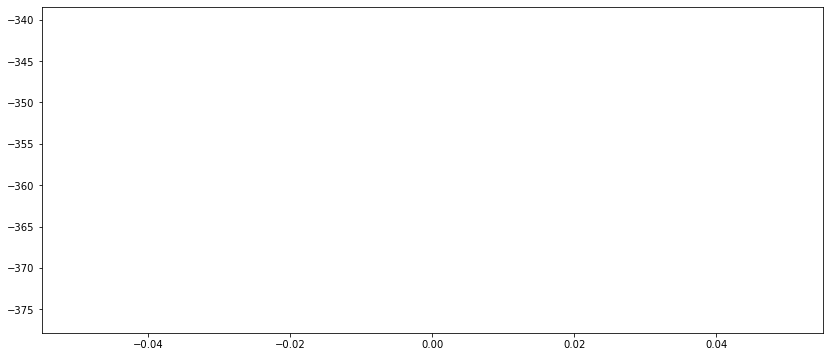

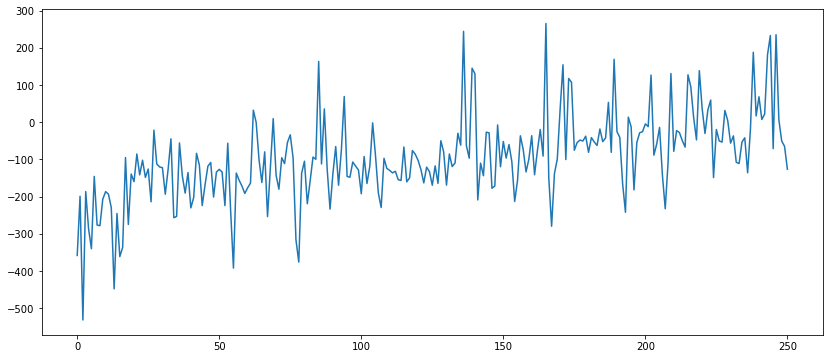

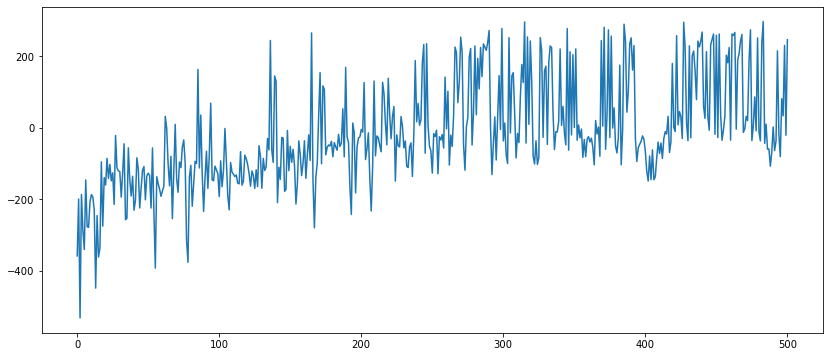

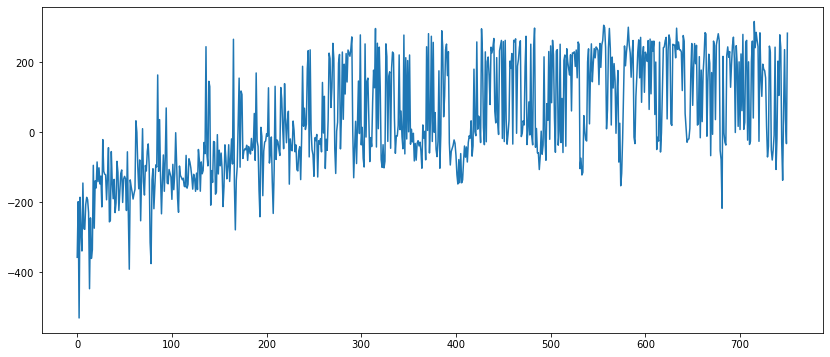

In [ ]:
# Uczenie/testowania agenta
env = gym.make("LunarLander-v2")
agent = NeuralQLearningAgent(env, alpha=0.0005)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [ ]:
test_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=False, plot_interval=250)
np.mean(test_rewards)

185.54787993121207

**Agent z double deep q-learning**

Wersja z double deep q-learning osiągneła najelpszy wynik powyżej 240. Mimo spadku nagród przed 500 epizodem, agent odnalazł lepsze polityki.

34.011760556697844 min


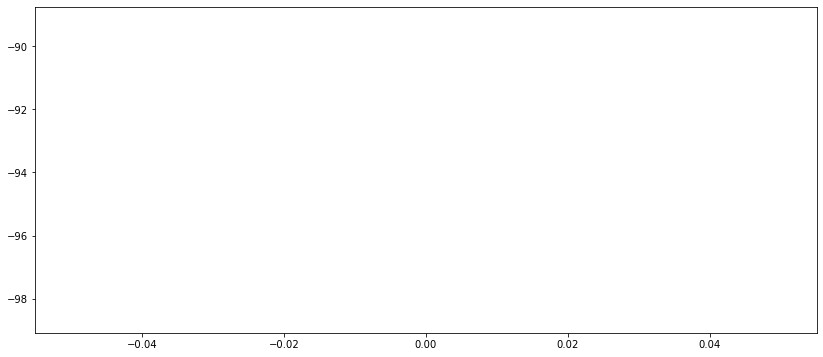

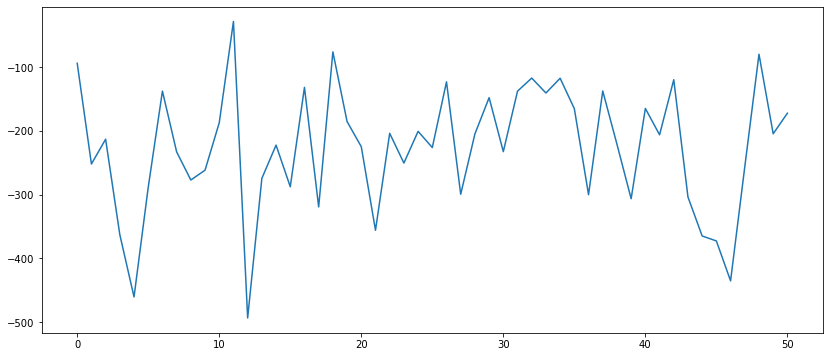

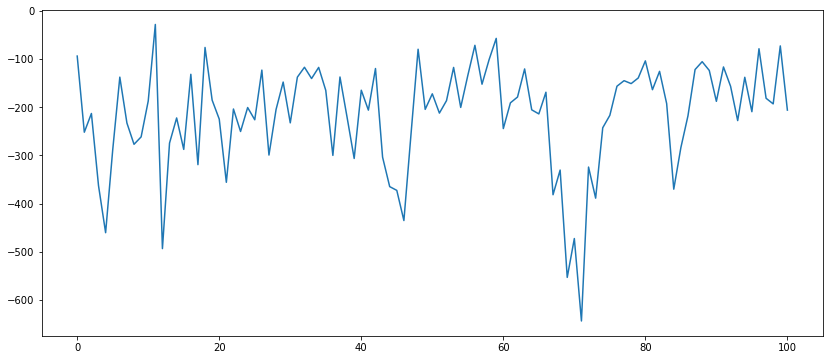

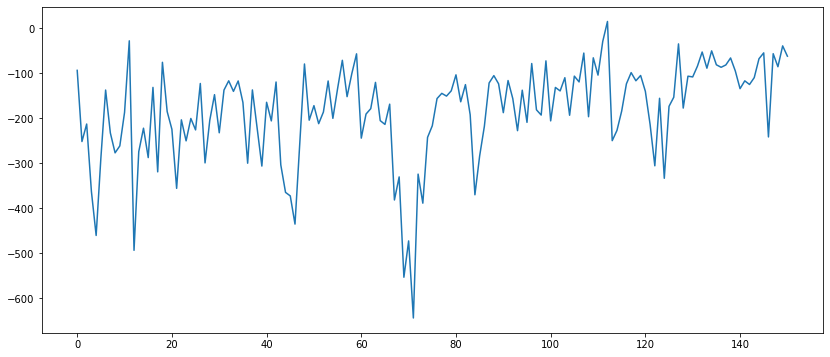

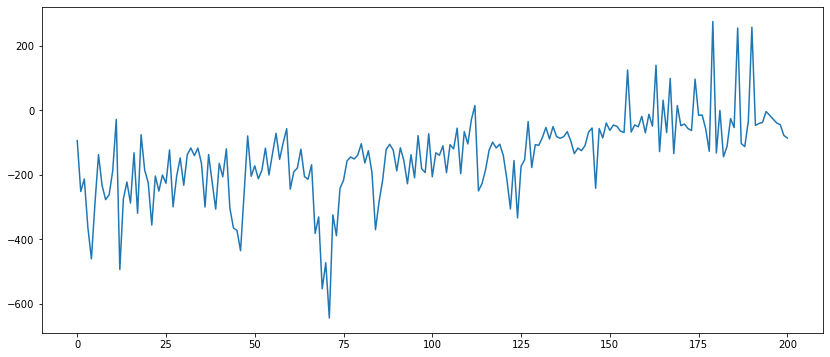

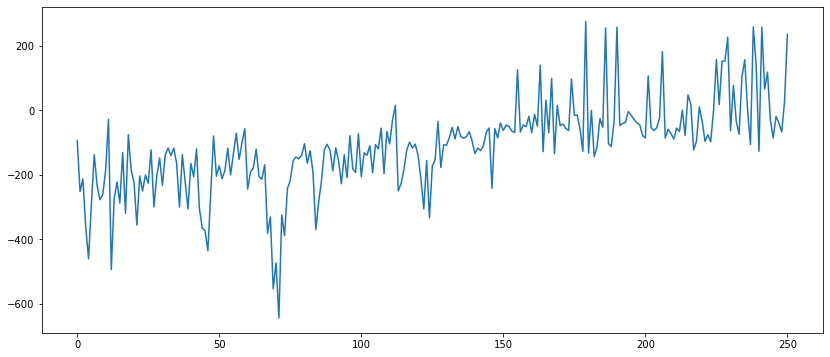

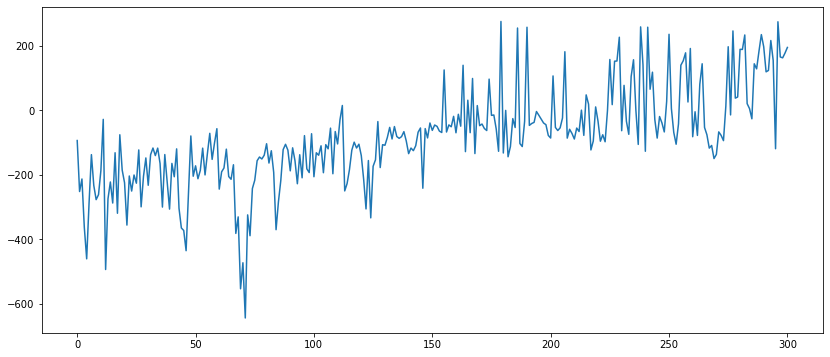

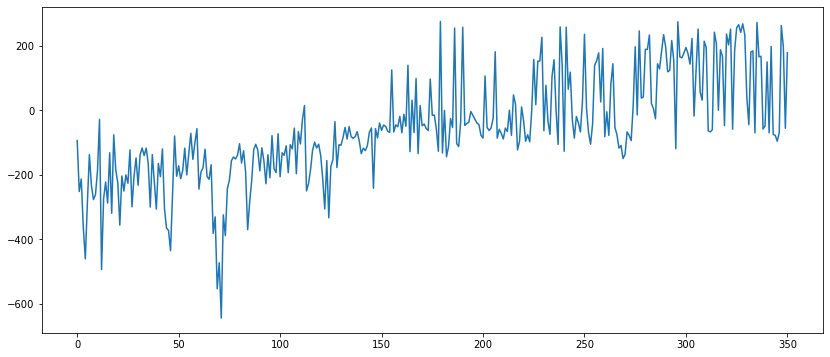

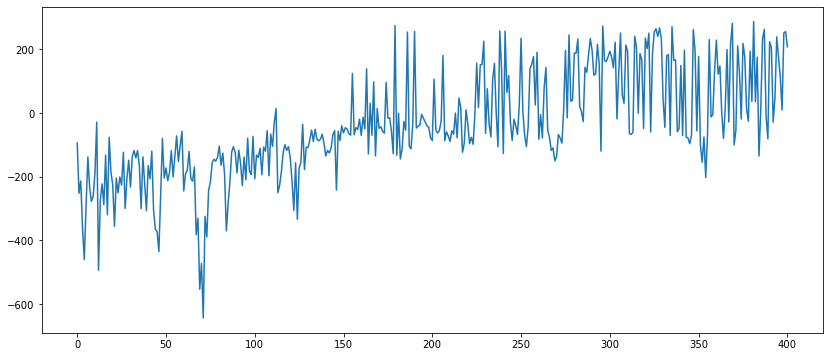

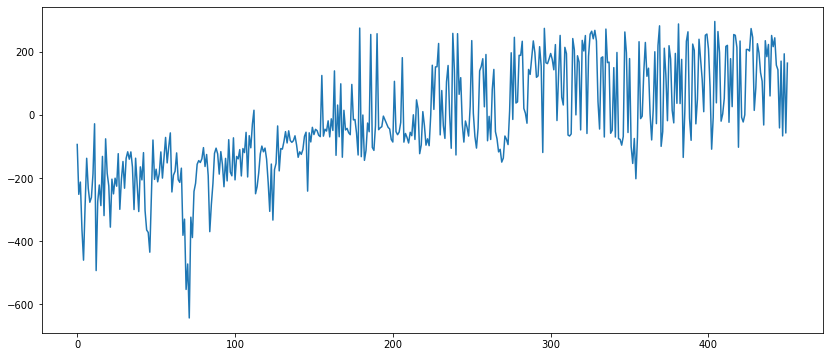

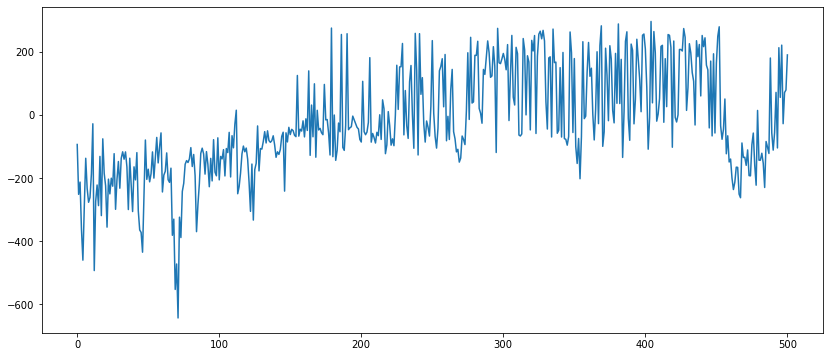

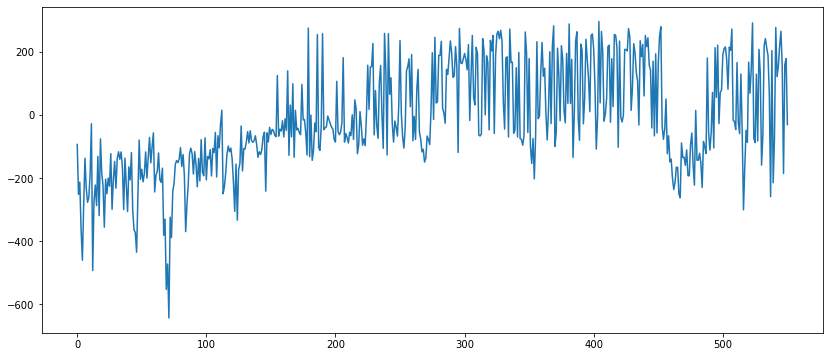

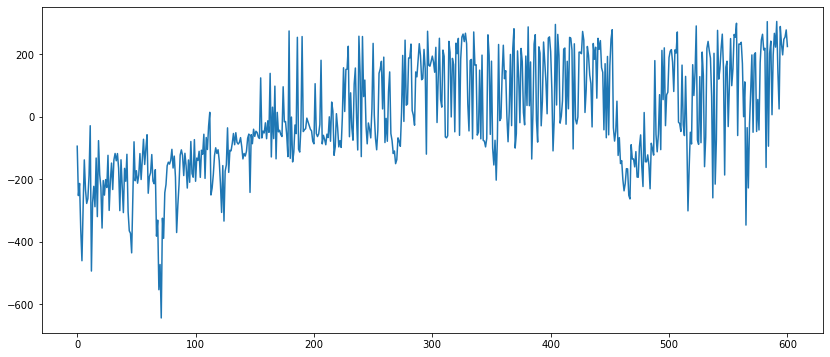

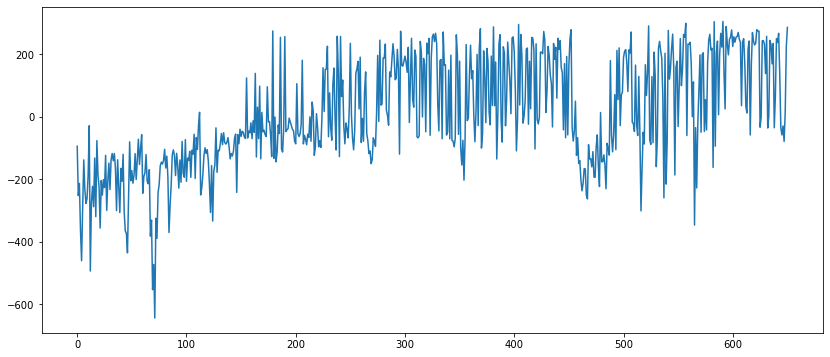

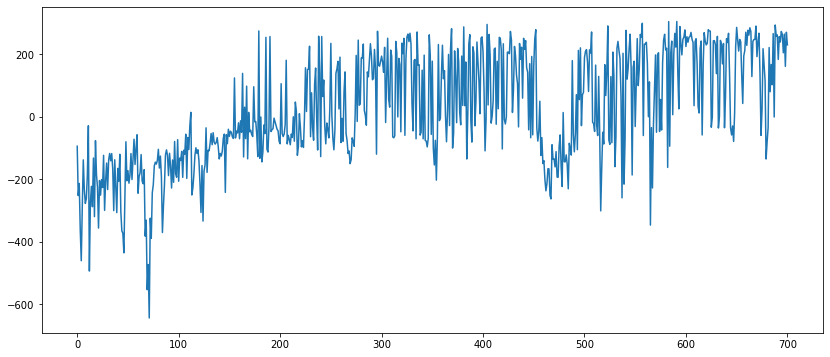

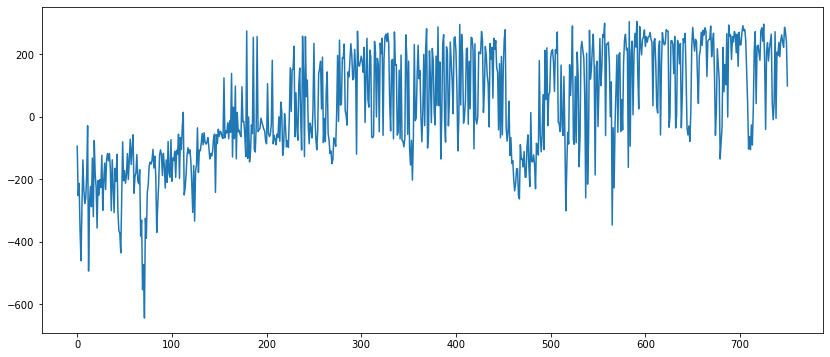

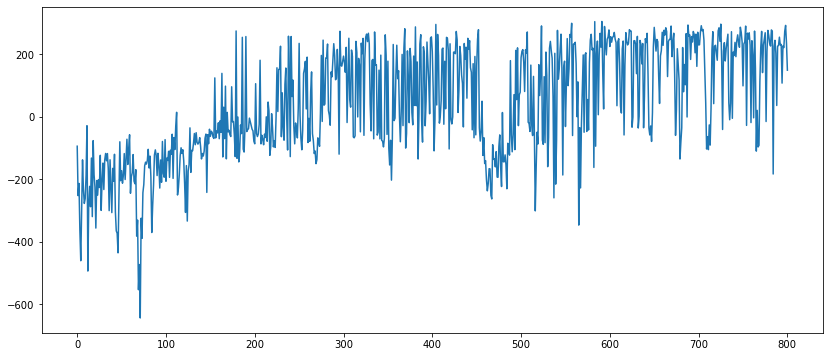

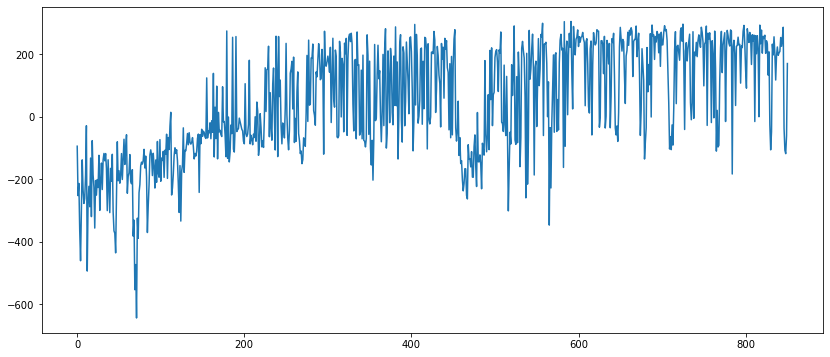

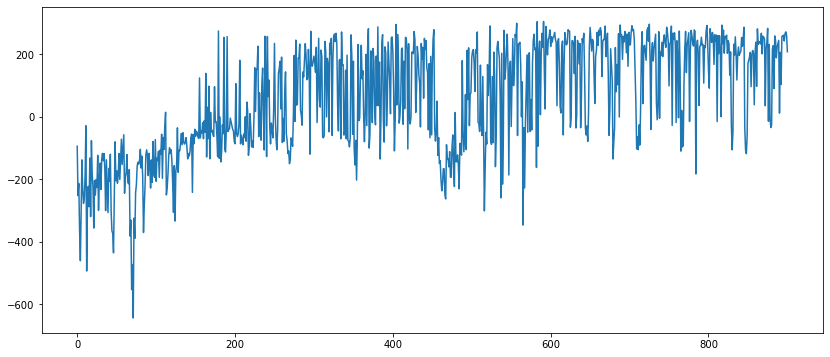

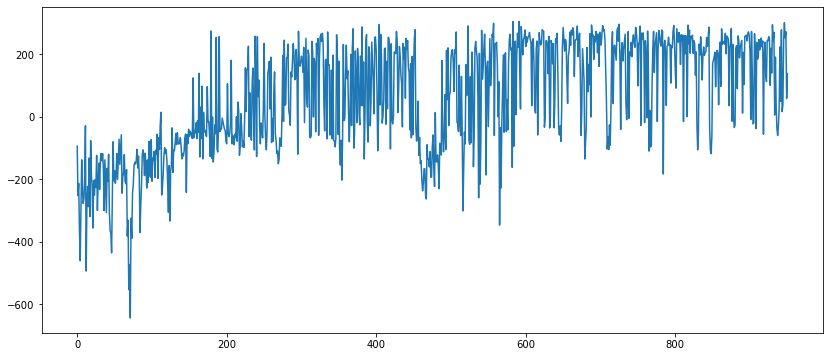

In [ ]:
from time import time
t = time()
env = gym.make("LunarLander-v2")
agent3 = NeuralQLearningAgent(env, alpha=0.0005, use_replay_memory=False, use_double_q=True, use_freezing=False)
rewards = run_agent_in_env(env, agent3, 1000, learning=True, plot=True, plot_interval=50)
print(f"{(time() - t )/60} min")

In [ ]:
test_rewards = run_agent_in_env(env, agent3, 1000, learning=False, plot=False, plot_interval=250)
np.mean(test_rewards)

243.524411409982

**Agent z memory replay**

Zastosowane batch o wielskosci 32 i pamiec o wielkosci 1000. 

Poprawiono wynik z wersji bez ulepszeń z 180 na 230. Jednak DQN ma lepsza srednia nagrod.

39.055248669783275 min


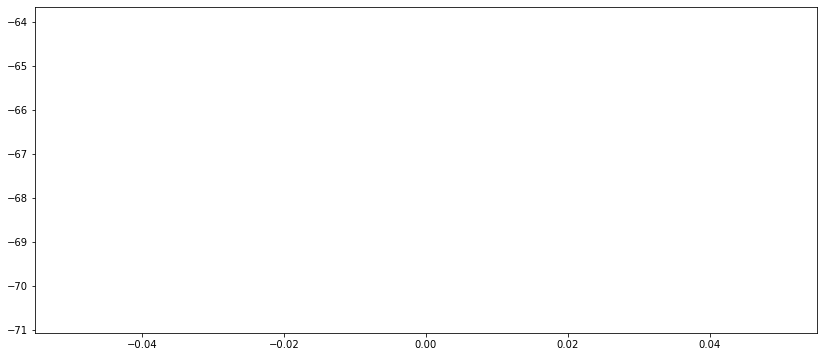

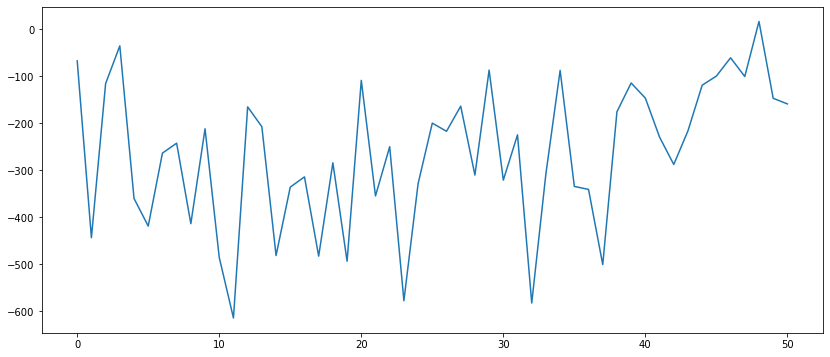

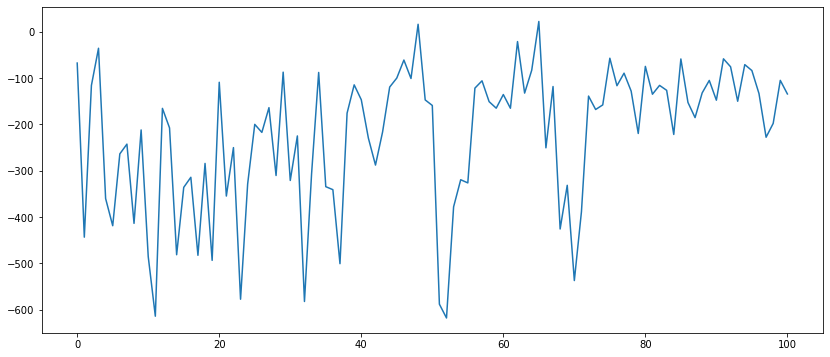

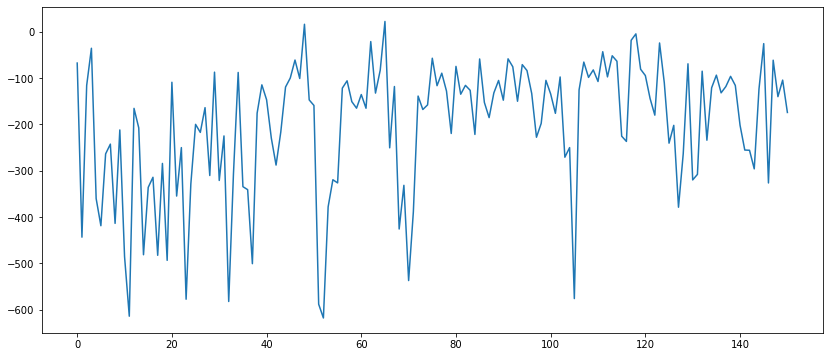

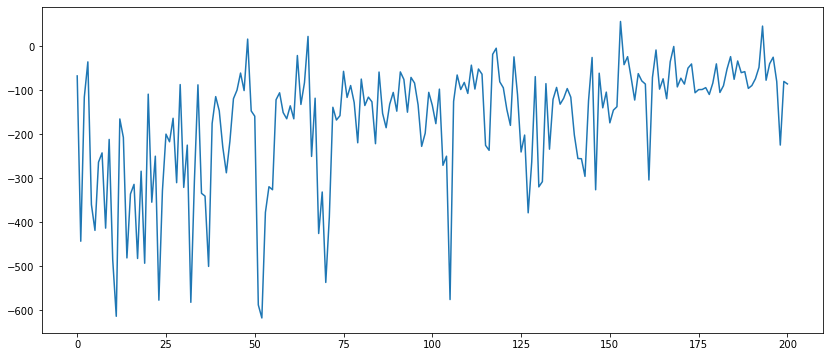

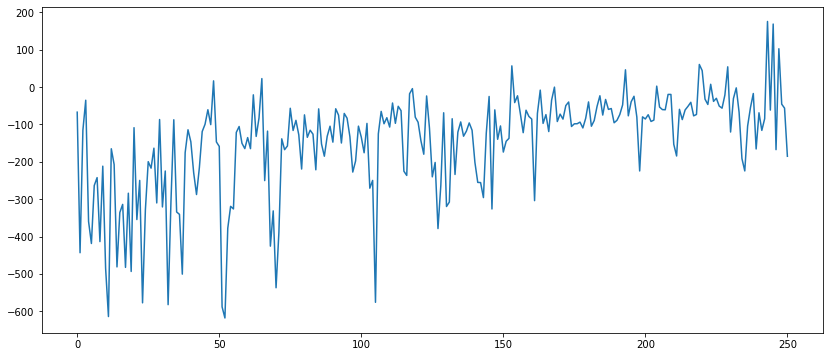

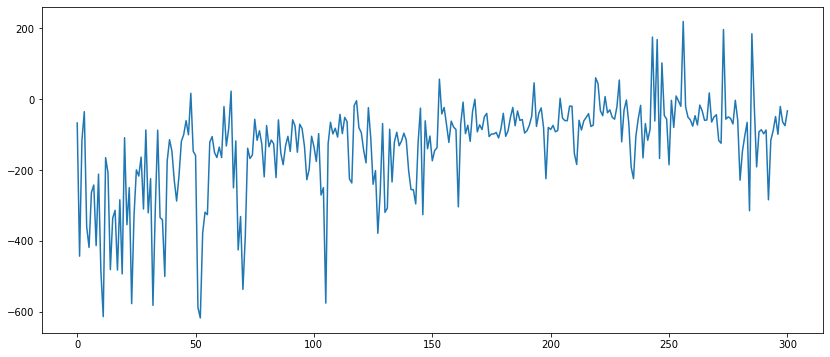

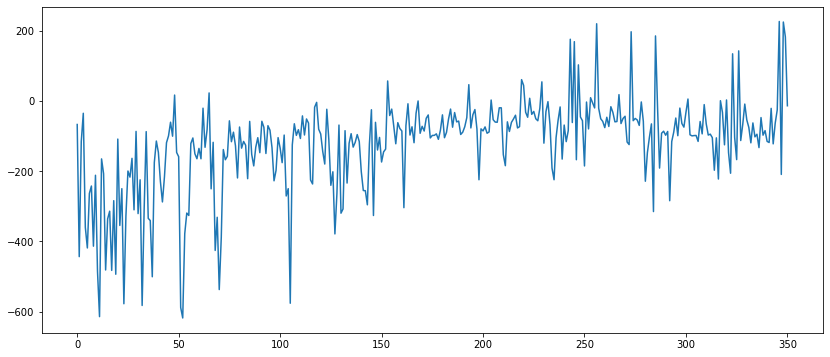

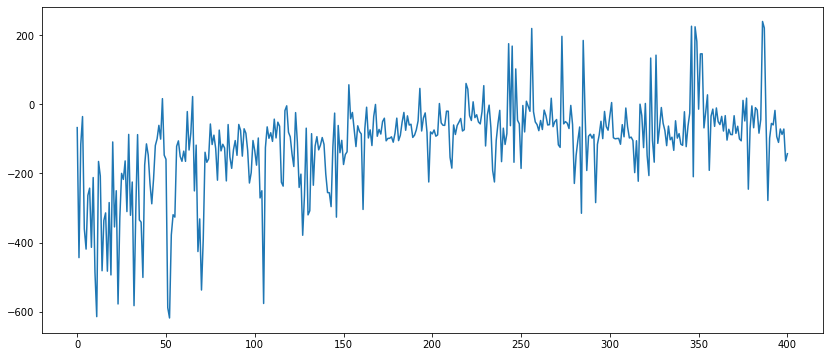

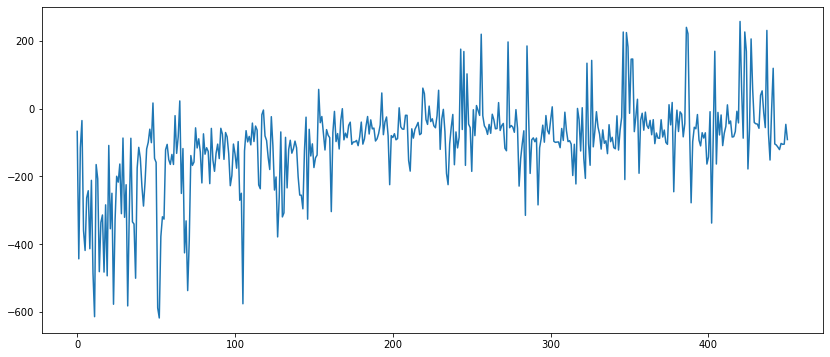

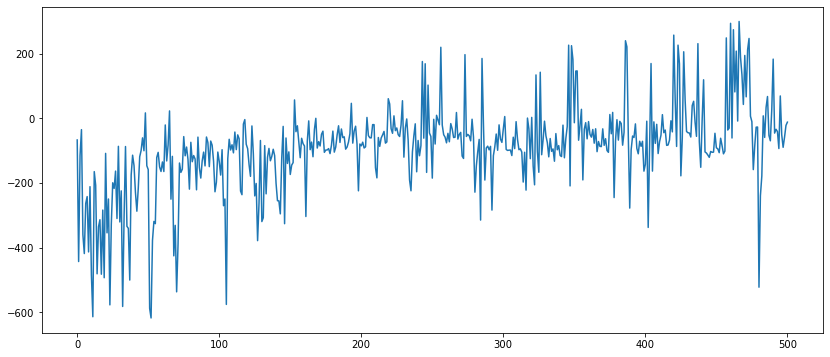

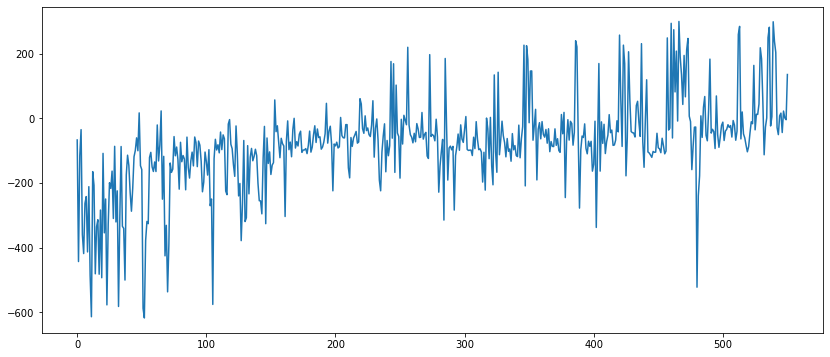

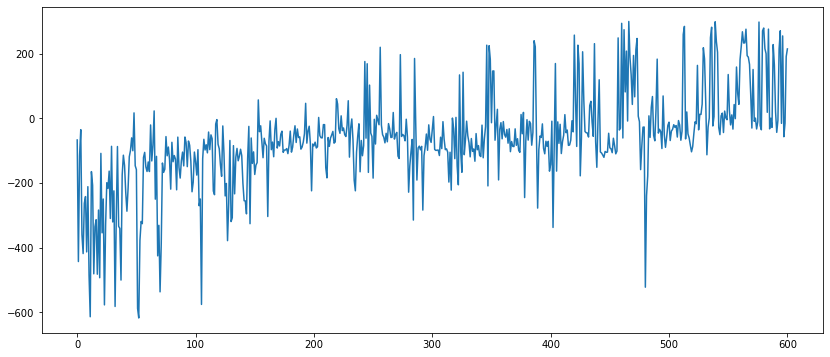

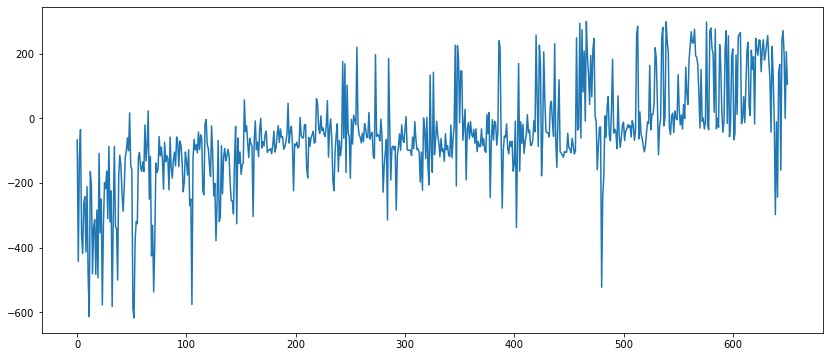

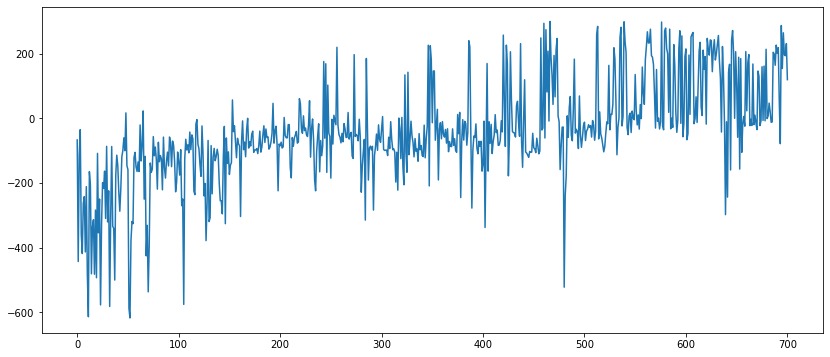

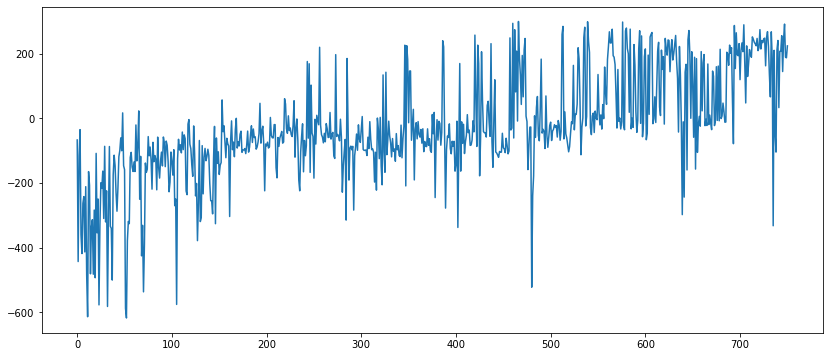

In [ ]:
from time import time
t = time()
env = gym.make("LunarLander-v2")
agent4 = NeuralQLearningAgent(env, alpha=0.0005, use_replay_memory=True, use_double_q=False, use_freezing=False)
rewards = run_agent_in_env(env, agent4, 800, learning=True, plot=True, plot_interval=50)
print(f"{(time() - t )/60} min")

In [ ]:
test_rewards = run_agent_in_env(env, agent4, 100, learning=False, plot=False, plot_interval=50)
np.mean(test_rewards)

230.36778376242646

**Agent z network freezing**

Agent z zamrażeniem sieci nie poprawił wynik agetna bez ulepszeń. Zastsowane częstotliwosc odmrażania równa 10 epizodów.

21.795610733826955 min


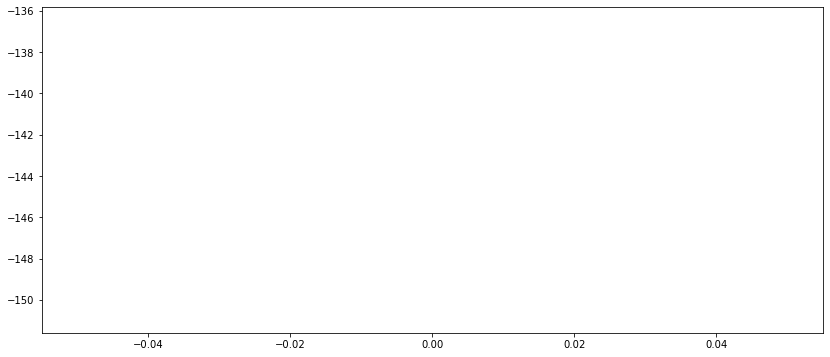

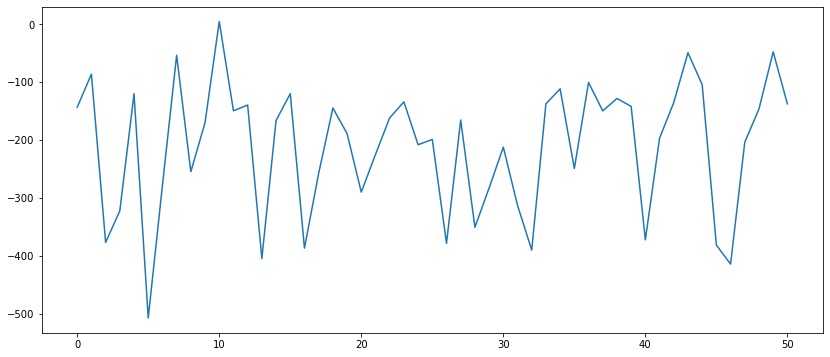

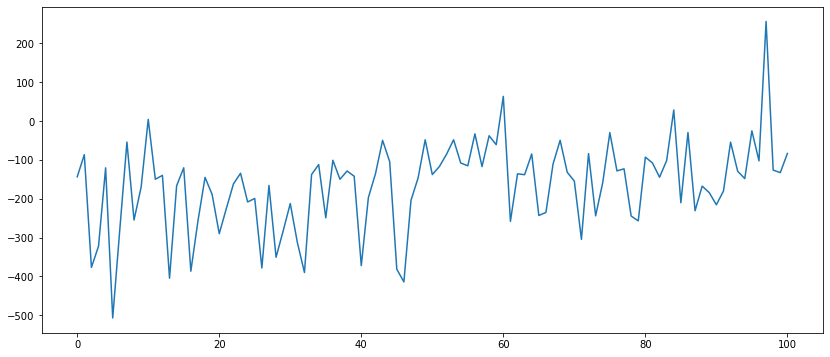

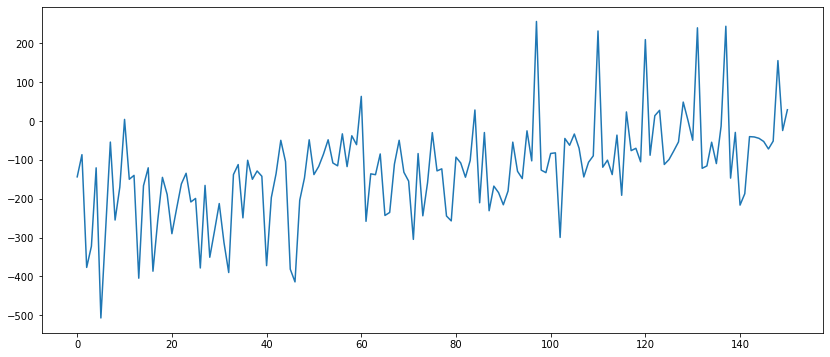

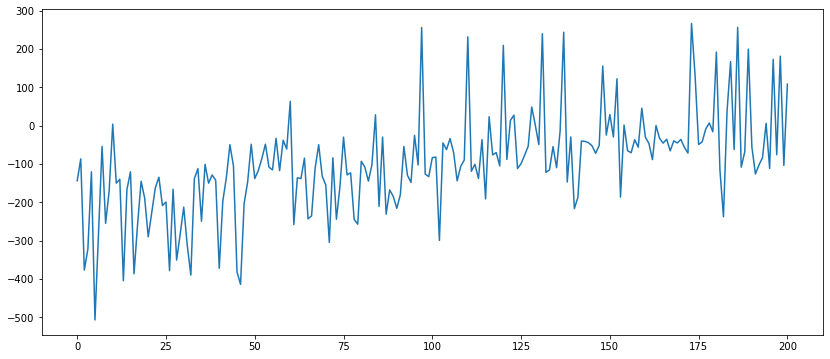

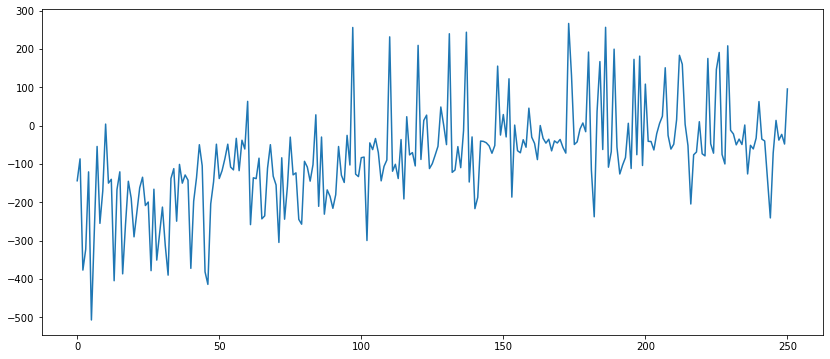

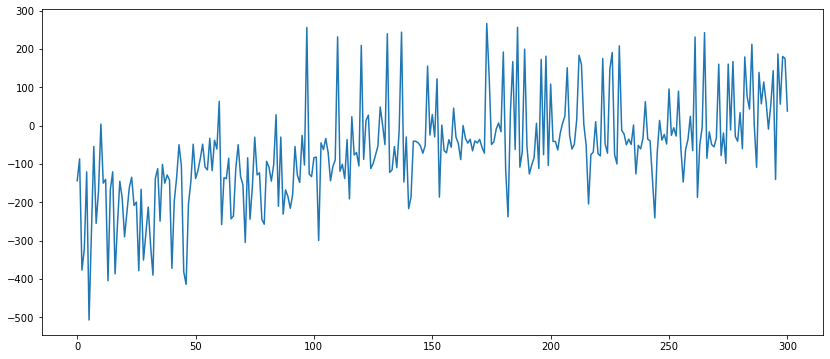

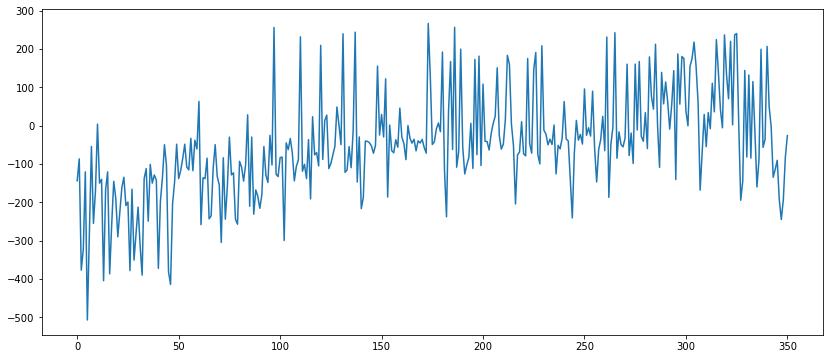

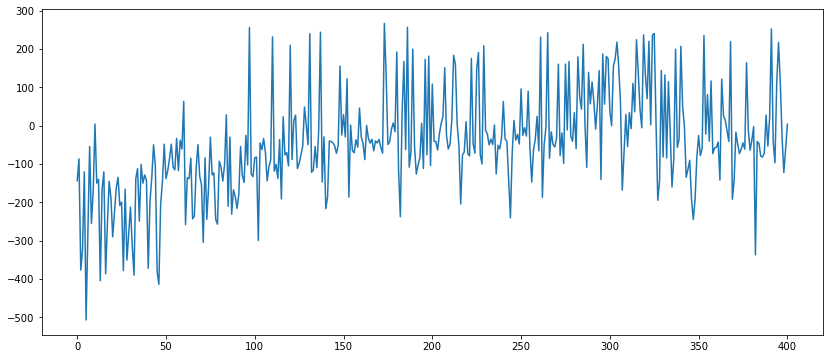

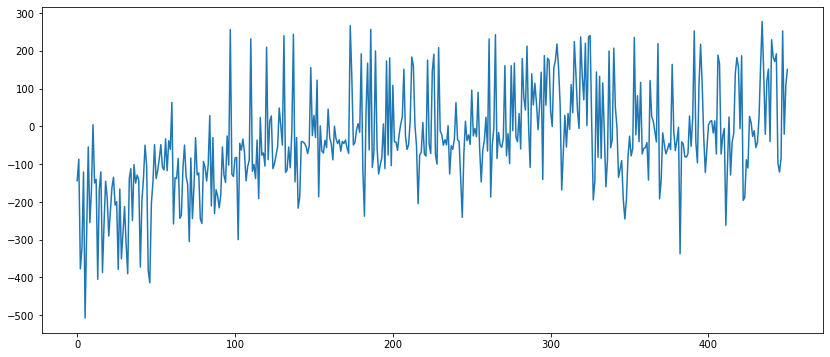

In [ ]:
from time import time
t = time()
env = gym.make("LunarLander-v2")
agent5 = NeuralQLearningAgent(env, alpha=0.0005, use_replay_memory=False, use_double_q=False, use_freezing=True)
rewards = run_agent_in_env(env, agent5, 500, learning=True, plot=True, plot_interval=50)
print(f"{(time() - t )/60} min")

In [ ]:
test_rewards = run_agent_in_env(env, agent5, 100, learning=False, plot=False, plot_interval=50)
np.mean(test_rewards)

64.27494193803572